## ovr-svm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string

from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression,SGDClassifier

from tqdm import *

%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [4]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.plotting import plot_micro_f1_at_k

In [27]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-ovr-linear-svc-calibrated/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS
SEED= 42

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [10]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [11]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [28]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    # https://stackoverflow.com/a/39712590/436721
    ('clf', OneVsRestClassifier(CalibratedClassifierCV(LinearSVC(),cv=2),n_jobs=-1)),
])

parameters = [
    { 
        "vect__max_features": [100,200,500,1000,2000,5000]
    }
]

In [29]:
%%time

for g in ParameterGrid(parameters):
    print(g)
    pipeline.set_params(**g)
    
    pipeline.fit(X_train,Y_train)
    
    Y_pred_train = pipeline.predict_proba(X_train)    
    Y_pred_val = pipeline.predict_proba(X_val)
    
    ks = [1,2,3,4,5,6,7,8,9,10]
        
    # k is the number of neighbors so let's use at_k
    for k in ks:
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True))) 
    

{'vect__max_features': 100}
validation micro-F1 @1: 0.2920203735144312
validation micro-F1 @2: 0.26026805015131865
validation micro-F1 @3: 0.2356036246711488
validation micro-F1 @4: 0.2269222295659837
validation micro-F1 @5: 0.21314387211367672
validation micro-F1 @6: 0.2073062073062073
validation micro-F1 @7: 0.20288375653949214
validation micro-F1 @8: 0.196122380365348
validation micro-F1 @9: 0.19263399540872342
validation micro-F1 @10: 0.18624357703055983
{'vect__max_features': 200}
validation micro-F1 @1: 0.3149078726968174
validation micro-F1 @2: 0.28400852878464816
validation micro-F1 @3: 0.2719725164614944
validation micro-F1 @4: 0.25498699045967044
validation micro-F1 @5: 0.23879551820728293
validation micro-F1 @6: 0.22731277533039648
validation micro-F1 @7: 0.2199191102123357
validation micro-F1 @8: 0.21413513813380672
validation micro-F1 @9: 0.20695118328547382
validation micro-F1 @10: 0.2008405615666637
{'vect__max_features': 500}
validation micro-F1 @1: 0.38782051282051283


In [30]:
feats_100 = [0.2920203735144312, 0.26026805015131865,0.2356036246711488,0.2269222295659837,
0.21314387211367672,0.2073062073062073,0.20288375653949214, 0.196122380365348, 0.19263399540872342, 0.18624357703055983]

feats_200 = [0.3149078726968174,0.28400852878464816, 0.2719725164614944, 0.25498699045967044, 0.23879551820728293,
             0.22731277533039648, 0.2199191102123357,0.21413513813380672, 0.20695118328547382,0.2008405615666637]

feats_500 = [0.38782051282051283, 0.3358147229114971, 0.3049705139005897, 0.2851054762412103, 0.27058621282448,
             0.26026805015131865,0.2515207945375543, 0.24125874125874125,0.23129517483883572,0.22418358340688438]

feats_1000 = [0.4244322631166797, 0.3655564581640942, 0.3339773668230748,0.30354131534569984, 0.28795098706603134,
              0.2722198368398454, 0.2605903421020131, 0.25252415590055366, 0.24330616996507567,0.2352425225857381]

feats_2000 = [0.4354587869362364, 0.3865276663993585, 0.34448710916072406,0.32263443101292205, 0.3012495778453225,
              0.28425241614553726, 0.2719018404907975,0.26045606830217227, 0.25262954742835086,0.2427947598253275]

feats_5000 = [0.4415182029434547, 0.3793797825211438, 0.3463013698630137, 0.3159656831973216,0.30411328388401887,
              0.28693060876968923, 0.2731731240804316, 0.26158332433308135, 0.2517860590847654, 0.2446344442505671]

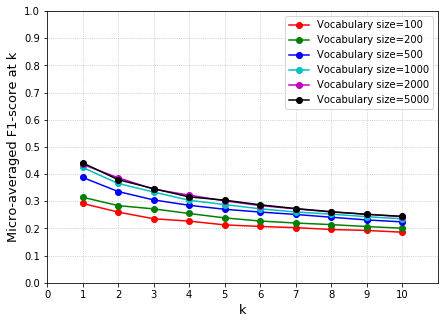

In [33]:
plt.clf()
ax = plt.gca()

ks = range(1, 11)



ax.plot(ks, feats_100, 'ro-', label='Vocabulary size=100')

ax.plot(ks, feats_200, 'go-', label='Vocabulary size=200')

ax.plot(ks, feats_500, 'bo-', label='Vocabulary size=500')

ax.plot(ks, feats_1000, 'co-', label='Vocabulary size=1000')

ax.plot(ks, feats_2000, 'mo-', label='Vocabulary size=2000')

ax.plot(ks, feats_5000, 'ko-', label='Vocabulary size=5000')

ax.set_xlim(0, 11)
ax.set_ylim(0, 0.5)
ax.set_xlabel('k', fontsize=13)

ax.set_ylabel('Micro-averaged F1-score at k', fontsize=13)

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)
plt.gcf().set_size_inches(7,5)
ax.legend()
plt.show()

In [ ]:
pickle.dump(pipeline,open(MODELS_ROOT+'/model.p','wb'))

In [ ]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
validation_scores = [
    0.38782051282051283,0.3358147229114971,
    0.3049705139005897,0.2851054762412103,
    0.27058621282448,0.26026805015131865,
    0.2515207945375543,0.24125874125874125,
    0.23129517483883572,0.22418358340688438
]
plot_micro_f1_at_k(validation_scores,ax)
plt.gcf().set_size_inches(7,5)
plt.gca().legend_.remove()
plt.show()